In [1]:
import numpy as np 
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
from scipy.optimize import curve_fit
from scipy.interpolate import *
import os



In [2]:
### This loads in every .txt file in the specified path 
### It is slightly hardcoded for the specific data format produced by SPRAria, but should be easily
### changeable to other formats
def loader(adir):
    i = 0
    names = os.listdir(adir)
    d = {}
    for i in range(0,np.size(names)):
        print(names[i])
        if names[i][-4:] == ".txt":
            try:
                d[str(names[i][:-4])] = np.loadtxt(adir+str(names[i]),skiprows=1,usecols=(0,1))
            except IndexError:
                print("Data file "+str(names[i])+" did not contain SPR data")
    #print(d)
    return(d)

In [3]:



### This produces two plots:
### The first is the SPR curve for the files "conc0", "conc1" up to "conc(num)" which you specify /
### when calling the function, and then plots "rinse" at the end.
### "conc" and "rinse" are the default names but can be passed as arguments to the function
### The second plot is the same as the first but with the addition of splines for each concentration.
### The equilibrium pixel valu for each concentration is then taken as the end value of each spline
### The function then returns these pixel values for each concentraion, along with an error which is /
### the width of the grey regions around each spline
### The second plot is to visually confirm that the splines are reasonable. If not, you can change the /
### value of the smoothing parameter from it's default of 10

def Organise(d,num,filename="conc",rinsename="rinse",smoothing=10):
    plt.figure(figsize=(14,10))
    for i in range(0,num):
        #print(d[filename+`i+1`][-1,0])
        #print(d[filename+`i`][-1,0])
        #print(np.size(d[filename+`i+1`]))
        if np.size(d[filename+`i+1`])!=0:
            #print(np.size(d[filename+`i+1`]))
            for j in range(0,np.size(d[filename+`i+1`][:,0])):
                #print(j)
                if np.size(d[filename+`i`])!=0:
                    d[filename+`i+1`][j][0] =d[filename+`i+1`][j][0] + d[filename+`i`][-1][0]
                else:
                    d[filename+`i+1`][j][0] =d[filename+`i+1`][j][0] + d[filename+`i-1`][-1][0] + 60*10
        #print(d[filename+`i+1`][-1][0])
    for j in range(0,np.size(d[rinsename][:,0])):
        d[rinsename][j][0] =d[rinsename][j][0] + d[filename+str(num)][-1][0]
    
    d2 = {}
    errors = np.zeros(num+1)
    pixels = np.zeros(num+1)
    for i in range(0,num+1):
        #print(i)
        if np.size(d[filename+`i`])!=0:
            temparray = np.zeros(np.shape(d[filename+`i`]))
            errors[i] = np.max(d[filename+`i`][-50:,1]) - np.min(d[filename+`i`][-50:,1])
            f = UnivariateSpline(d[filename+`i`][:,0]/60, d[filename+`i`][:,1], s=smoothing)
            temparray[:,0] = d[filename+`i`][:,0]/60
            temparray[:,1] = f(d[filename+`i`][:,0]/60)
            d2[filename+`i`] = temparray
            pixels[i] = d2[filename+`i`][-1,1] - d2[filename+"0"][-1,1]
        
    return(d,d2,pixels,errors)

In [30]:
def Plotter(d,d2,pixels,errors,num,filename="conc",rinsename="rinse",ShowFits = False):
    plotdata1 = []
    cmap = plt.get_cmap('jet')
    colors = [cmap(i) for i in np.linspace(0, 1, num+2)]
    fig1 = plt.figure(figsize=(14,10))
    ax1 = fig1.add_subplot(1, 1, 1)
    
    
    if ShowFits==False:
        for i in range(0,num+1):
            if np.size(d[filename+`i`])!=0:
                plotdata1.append(ax1.plot(d[filename+`i`][:,0]/60,d[filename+`i`][:,1],label=filename+`i`,color=colors[i]))
        plotdata1.append(ax1.plot(d[rinsename][:,0]/60,d[rinsename][:,1],label=rinsename,color=colors[num+1]))
    else:
         for i in range(0,num+1):
            if np.size(d[filename+`i`])!=0:
                plotdata1.append(ax1.plot(d[filename+`i`][:,0]/60,d[filename+`i`][:,1],label=filename+`i`,color=colors[i]))
                plotdata1.append(ax1.plot(d2[filename+`i`][:,0],d2[filename+`i`][:,1],color='black',linewidth=3))
                plotdata1.append(ax1.fill_between(d2[filename+`i`][:,0],d2[filename+`i`][:,1]-errors[i]/2,d2[filename+`i`][:,1]+errors[i]/2,color='gray',edgecolor='black',alpha=0.4))
                plotdata1.append(ax1.plot(d2[filename+`i`][:,0],d2[filename+`i`][:,1],color='white',linewidth=1))

    ax1.set_title("BTK PH Domain in 75:20:05 DOPC:DOPS:PIP3")
    ax1.set_ylabel("SPR Signal (pixels)")
    ax1.set_xlabel("Time (minutes)")

    ax1.legend(prop={'size':10})
    #plt.show()
    #fig1.close()
    
    return(ax1,plotdata1)

In [31]:
def Langmuir(concs,bmax,kd,gamma):
    return (concs*bmax)/(concs+kd) + gamma*concs

In [32]:
def FitToLangmuir(concs,pixels,errors):
    ### Change "bounds = " below to be reasonable range for gamma
    popt, popv = curve_fit(Langmuir,concs,pixels,sigma=errors,bounds=([0,0,0.72],[1000,1000,0.8]))
    plt.figure(figsize=(10,8))
    plt.errorbar(concs,pixels,yerr=errors/2,fmt='o')
    c2 = np.arange(0.01,100,0.01)
    plt.plot(c2,Langmuir(c2,*popt))
    plt.title("Langmuir Binding Curve")
    plt.xscale('log')
    plt.ylabel("R_eq")
    plt.xlabel("Concentration (um)")
    string = "bmax = " + str(popt[0])+" +- "+str(np.sqrt(popv[0][0])) + "\n" + "kd = " + str(popt[1])+" +- "+str(np.sqrt(popv[1][1])) + "\n" + "gamma = " + str(popt[2])+" +- "+str(np.sqrt(popv[2][2]))
    plt.text(0.4, 1.4, string, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.2))
    plt.show()
    
    print("bmax = ",str(popt[0])+" +- "+str(np.sqrt(popv[0][0])))
    print("kd = ",str(popt[1])+" +- "+str(np.sqrt(popv[1][1])))
    print("gamma = ",str(popt[2])+" +- "+str(np.sqrt(popv[2][2])))
    return(popt,popv)

In [41]:
def ReducedChiSquared(concs,pixels,popt):
    ans = 0.0
    for i in range(0,len(concs)):
        ans = ans + (pixels[i] - Langmuir(concs[i],*popt))**2
    ans = ans /(len(concs) - len(popt))    
    return ans

.DS_Store
2017-6-8Bilayer1-SPR.png
conc0.txt
conc1.txt
conc10.txt
conc11.txt
conc2.txt
conc3.txt
conc4.txt
conc5.txt
conc6.txt
conc7.txt
conc8.txt
conc9.txt
CorrectedLangmuir.png
finalrinse.txt
Models-Linear.png
Models-Log.png
NaiveLangmuir.png
SPR_Analysis-IBBR.ipynb
1
2
3
4
5
6
7
8
9
10
11
Final rinse is not plotted if ShowFits==True


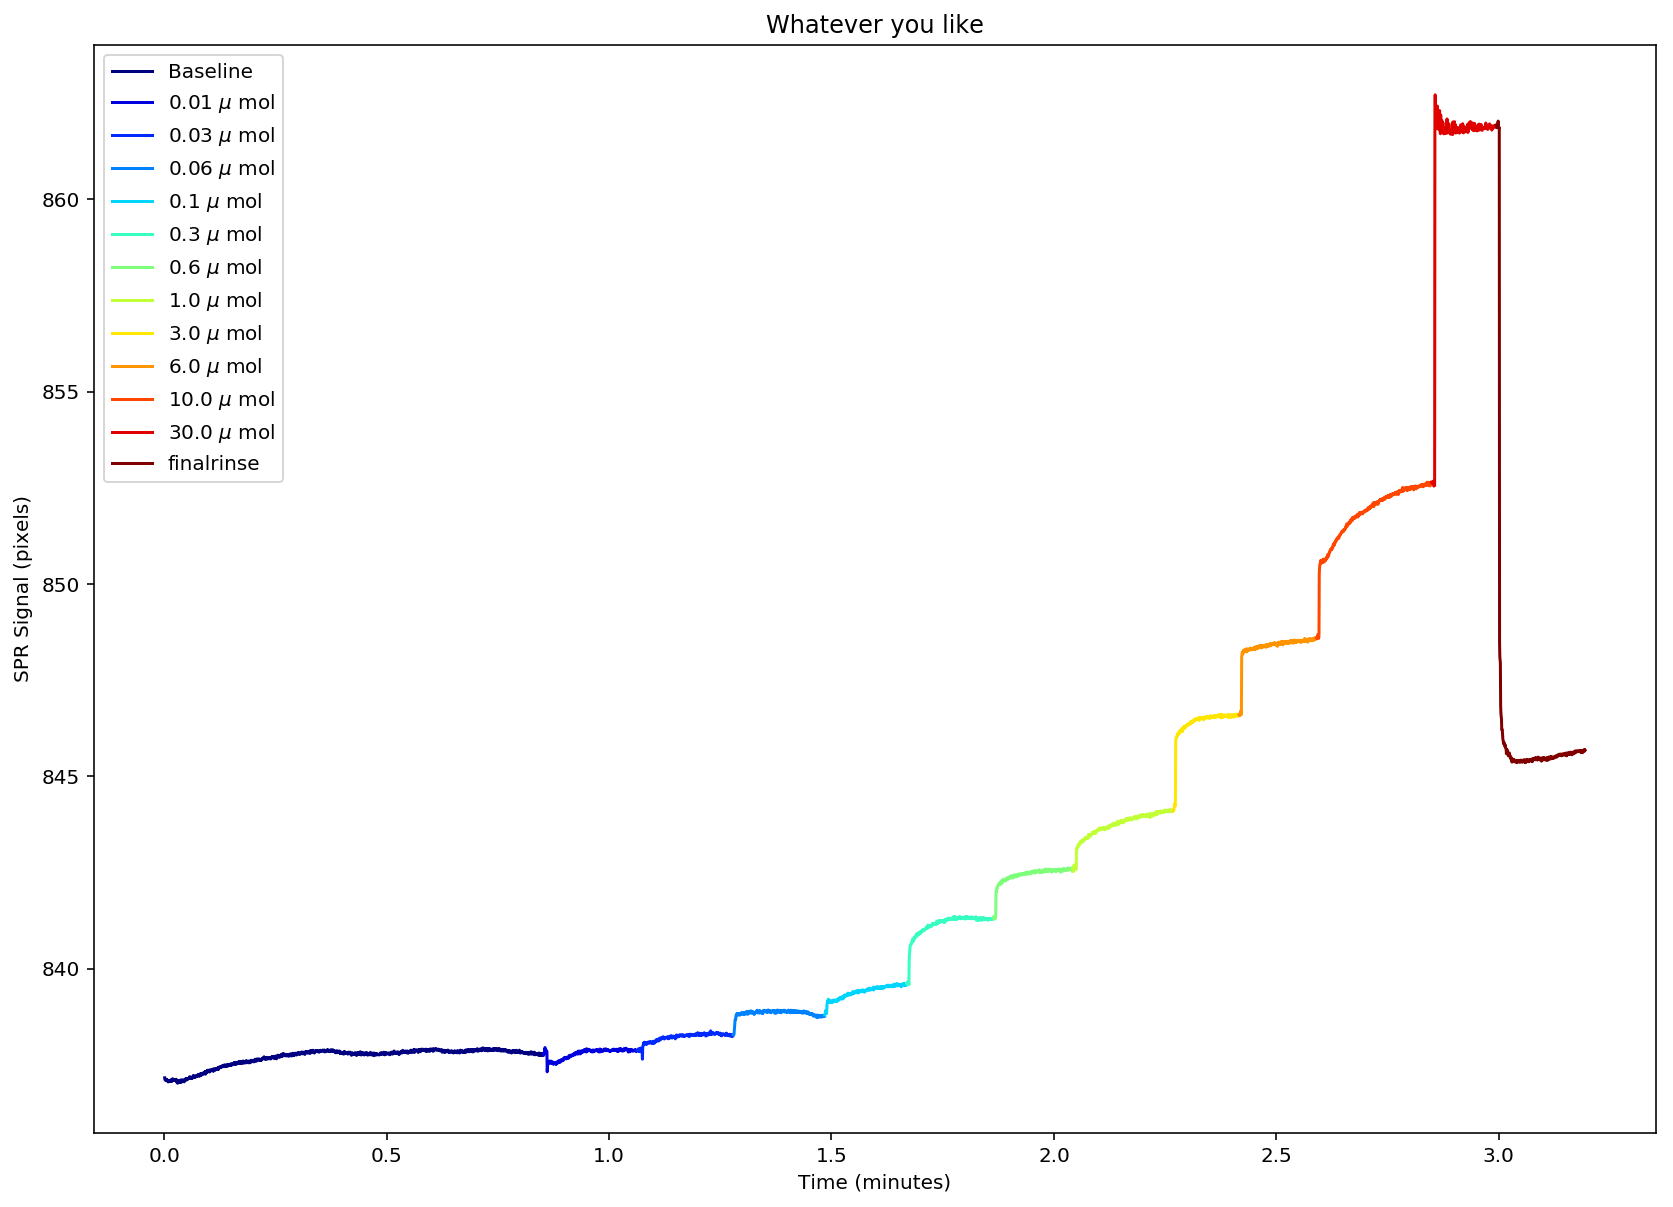

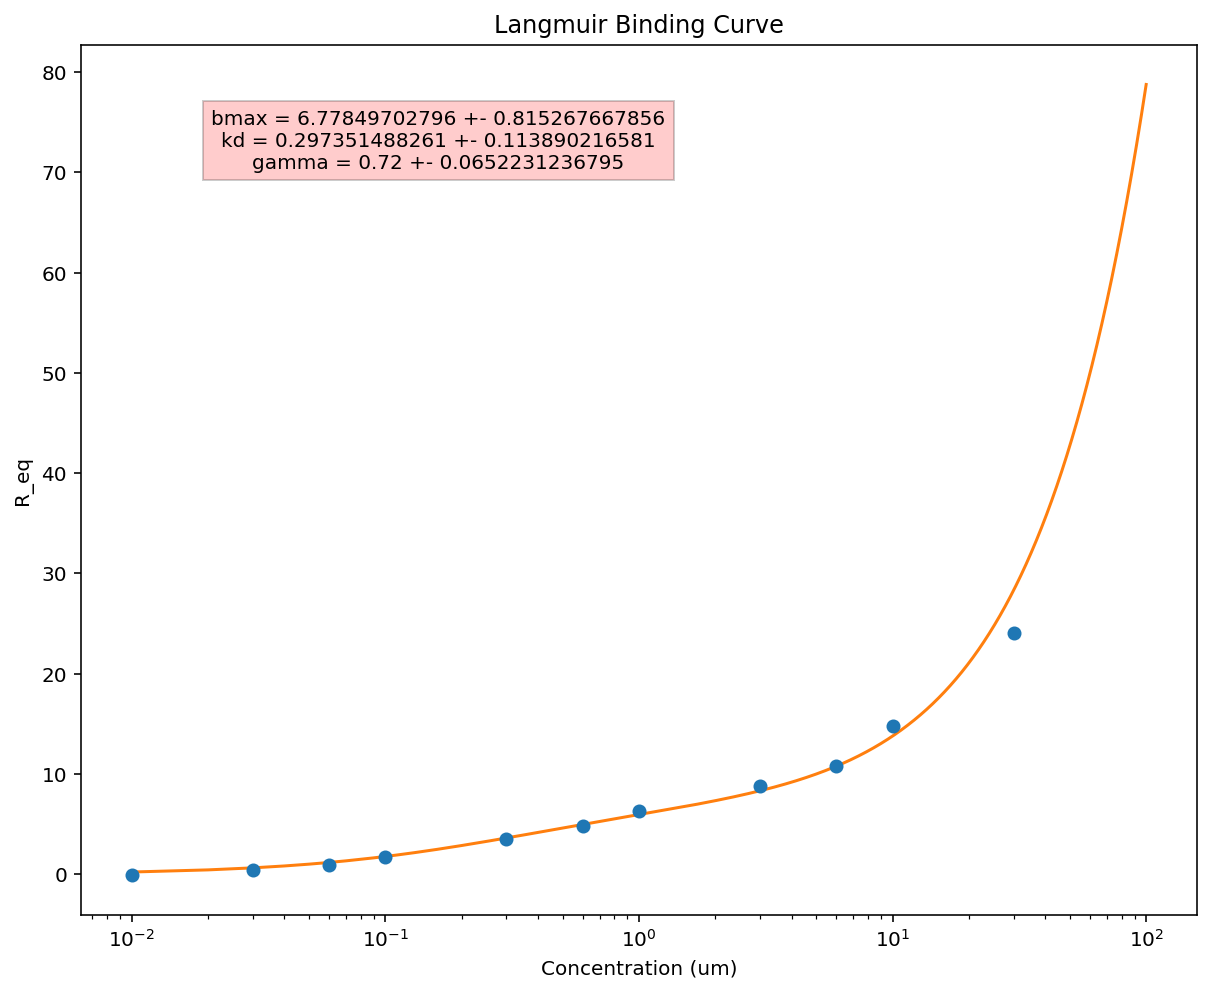

('bmax = ', '6.77849702796 +- 0.815267667856')
('kd = ', '0.297351488261 +- 0.113890216581')
('gamma = ', '0.72 +- 0.0652231236795')


In [42]:

###The various concentrations have to be manually added below in micromolar (first concentation should be zero for baseline)
concs = np.array([0,0.01,0.03,0.06,0.100,0.300,0.600,1.0,3.0,6.0,10.0,30.0])

#NUMBER OF NON-ZERO CONCENTRATIONS MEASURED:

num = np.size(concs) - 1

#THE DIRECTORY WITH ALL THE DATA GOES HERE
d = loader("../../../Downloads/IBBR/")


(d,d2,pixels,errors) = Organise(d,num,filename="conc",rinsename="finalrinse",smoothing=5)
(ax,pd) = Plotter(d,d2,pixels,errors,num,filename="conc",rinsename="finalrinse",ShowFits=False)



#THIS AUTOLABELS VIA THE CONCENTRATIONS
pd[0][0].set_label("Baseline")
for i in range(1,np.size(concs)):
    print(i)
    if np.size(pd) == num+2:
        pd[i][0].set_label(str(concs[i])+r' $\mu$ mol') 
    else:
        pd[i*4][0].set_label(str(concs[i])+r' $\mu$ mol')
try:
    pd[(np.size(concs)+1)*4][0].set_label("Rinse")
except IndexError:
    print("Final rinse is not plotted if ShowFits==True")
    

ax.set_title("Whatever you like")
###    
ax.legend()
plt.show(ax)
popt,popv = FitToLangmuir(concs,pixels,errors)

In [43]:
chi = ReducedChiSquared(concs,pixels,popt)
print(chi)

2.17760489787


In [44]:
print(pixels)
print(concs)
print(errors)

[  0.          -0.03467638   0.44107555   0.9310916    1.75882088
   3.52862145   4.83499246   6.34560786   8.76523791  10.75866736
  14.74329557  24.05458819]
[  0.00000000e+00   1.00000000e-02   3.00000000e-02   6.00000000e-02
   1.00000000e-01   3.00000000e-01   6.00000000e-01   1.00000000e+00
   3.00000000e+00   6.00000000e+00   1.00000000e+01   3.00000000e+01]
[ 0.095  0.101  0.083  0.095  0.087  0.074  0.111  0.092  0.081  0.113
  0.131  0.183]


In [ ]:
con = np.arange(0.01,10,0.01)
#print(con)
plt.plot(con,(con*44.3)/(con+0.477))
plt.show()